# 6-1，构建模型的3种方法

可以使用以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

对于顺序结构的模型，优先使用Sequential方法构建。

如果模型有多输入或者多输出，或者模型需要共享权重，或者模型具有残差连接等非顺序结构，推荐使用函数式API进行创建。

如果无特定必要，尽可能避免使用Model子类化的方式构建模型，这种方式提供了极大的灵活性，但也有更大的概率出错。

下面以IMDB电影评论的分类问题为例，演示3种创建模型的方法。

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import *


train_token_path = "./data/imdb/train_token.csv"
test_token_path = "./data/imdb/test_token.csv"

MAX_WORDS = 10000  # We will only consider the top 10,000 words in the dataset
MAX_LEN = 200  # We will cut reviews after 200 words
BATCH_SIZE = 20 

In [2]:
# 构建管道
def parse_line(line):
    t = tf.strings.split(line,"\t")
    label = tf.reshape(tf.cast(tf.strings.to_number(t[0]),tf.int32),(-1,))
    features = tf.cast(tf.strings.to_number(tf.strings.split(t[1]," ")),tf.int32)
    return (features,label)

ds_train=  tf.data.TextLineDataset(filenames = [train_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

ds_test=  tf.data.TextLineDataset(filenames = [test_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)


In [3]:
ds_train

<PrefetchDataset shapes: ((None, None), (None, 1)), types: (tf.int32, tf.int32)>

In [4]:
for item in ds_train.take(1):
    print(item)

(<tf.Tensor: shape=(20, 200), dtype=int32, numpy=
array([[ 766,   35,    6, ...,   11, 4398, 5665],
       [   0,    0,    0, ...,   38,    1, 2803],
       [  89, 4072,   96, ..., 6637, 6148,    1],
       ...,
       [   0,    0,    0, ...,  335,   15,  116],
       [  53,   35,    5, ...,   78,    5, 8892],
       [   0,    0,    0, ...,  763, 1420, 1602]], dtype=int32)>, <tf.Tensor: shape=(20, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=int32)>)


## 一，Sequential按层顺序创建模型

In [5]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
model.add(layers.Conv1D(filters =64,kernel_size =5,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters =32,kernel_size =3,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="Nadam",loss="binary_crossentropy",metrics=["accuracy","AUC"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [6]:
import datetime
baselogger = callbacks.BaseLogger(stateful_metrics=["AUC",])
logdir = "./data/keras_model/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
history = model.fit(ds_train,validation_data=ds_test,epochs=6,callbacks=[tensorboard_callback])

Epoch 1/6
      1/Unknown - 0s 103us/step - loss: 0.6937 - accuracy: 0.4000 - auc: 0.5000WARNING:tensorflow:From /home/work/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4714 - accuracy: 0.7413 - auc: 0.8456 - val_loss: 0.3116 - val_accuracy: 0.8632 - val_auc: 0.9411
Epoch 2/6
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2415 - accuracy: 0.9055 - auc: 0.9647 - val_loss: 0.3370 - val_accuracy: 0.8632 - val_auc: 0.9451
Epoch 3/6
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1645 - accuracy: 0.9377 - auc: 0.9833 - val_loss: 0.3496 - val_accuracy: 0.8686 - val_auc: 0.9416
Epoch 4/6
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1115 - accuracy: 0.9591 - auc: 

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

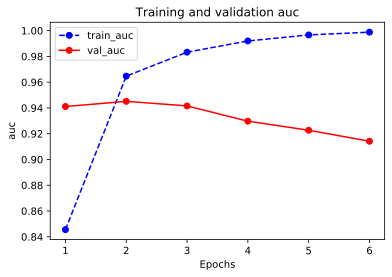

In [8]:
plot_metric(history,"auc")

## 二，函数式API创建任意结构模型

In [9]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[MAX_LEN])
x  = layers.Embedding(MAX_WORDS,7)(inputs)

branch1 = layers.SeparableConv1D(64,3,activation="relu")(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32,3,activation="relu")(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64,5,activation="relu")(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32,5,activation="relu")(branch2)
branch2 = layers.GlobalMaxPool1D()(branch2)

branch3 = layers.SeparableConv1D(64,7,activation="relu")(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32,7,activation="relu")(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1,branch2,branch3])
outputs = layers.Dense(1,activation = "sigmoid")(concat)

model = models.Model(inputs = inputs,outputs = outputs)

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 7)       70000       input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 198, 64)      533         embedding[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 196, 64)      547         embedding[0][0]                  
_______________________________________________________________________________________

In [10]:
import datetime
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,validation_data = ds_test,epochs = 6,callbacks=[tensorboard_callback])

Epoch 1/6
      2/Unknown - 0s 85ms/step - loss: 0.6926 - accuracy: 0.5250 - auc: 0.5455WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0066s vs `on_train_batch_end` time: 0.1637s). Check your callbacks.
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5838 - accuracy: 0.6496 - auc: 0.7339 - val_loss: 0.3905 - val_accuracy: 0.8284 - val_auc: 0.9108
Epoch 2/6
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3202 - accuracy: 0.8620 - auc: 0.9373 - val_loss: 0.3318 - val_accuracy: 0.8620 - val_auc: 0.9339
Epoch 3/6
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2218 - accuracy: 0.9115 - auc: 0.9701 - val_loss: 0.3510 - val_accuracy: 0.8668 - val_auc: 0.9356
Epoch 4/6
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1540 - accuracy: 0.9438 - auc: 0.9852 - val_loss: 0.3957 - val_accuracy: 0.8674 - val_auc: 0.9328
Epoch 5/6
1000/1000 [==========================

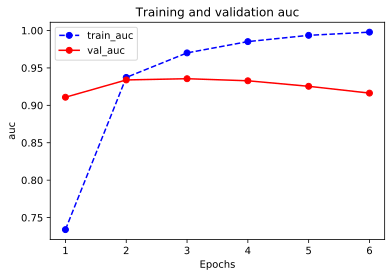

In [11]:
plot_metric(history,"auc")

## 三，Model子类创建自定义模型

In [12]:
# 先自定义一个残差模块，为自定义Layer

class ResBlock(layers.Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    
    def build(self,input_shape):
        self.conv1 = layers.Conv1D(filters=64,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv2 = layers.Conv1D(filters=32,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv3 = layers.Conv1D(filters=input_shape[-1],
                                   kernel_size=self.kernel_size,activation = "relu",padding="same")
        self.maxpool = layers.MaxPool1D(2)
        super(ResBlock,self).build(input_shape) # 相当于设置self.built = True
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.Add()([inputs,x])
        x = self.maxpool(x)
        return x
    
    #如果要让自定义的Layer通过Functional API 组合成模型时可以序列化，需要自定义get_config方法。
    def get_config(self):  
        config = super(ResBlock, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

In [13]:
# 测试ResBlock
resblock = ResBlock(kernel_size = 3)
resblock.build(input_shape = (None,200,7))
resblock.compute_output_shape(input_shape=(None,200,7))

TensorShape([None, 100, 7])

In [14]:
# 自定义模型，实际上也可以使用Sequential或者FunctionalAPI

class ImdbModel(models.Model):
    def __init__(self):
        super(ImdbModel, self).__init__()
        
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7)
        self.block1 = ResBlock(7)
        self.block2 = ResBlock(5)
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(ImdbModel,self).build(input_shape)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.block1(x)
        x = self.block2(x)
        x = layers.Flatten()(x)
        x = self.dense(x)
        return(x)


In [15]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape =(None,200))
model.summary()

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])


Model: "imdb_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  70000     
_________________________________________________________________
res_block (ResBlock)         multiple                  19143     
_________________________________________________________________
res_block_1 (ResBlock)       multiple                  13703     
_________________________________________________________________
dense (Dense)                multiple                  351       
Total params: 103,197
Trainable params: 103,197
Non-trainable params: 0
_________________________________________________________________


In [16]:
import datetime

logdir = "./tflogs/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,validation_data = ds_test,
                    epochs = 6,callbacks=[tensorboard_callback])


Epoch 1/6
      2/Unknown - 0s 72ms/step - loss: 0.6944 - accuracy: 0.5500 - auc: 0.5604WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 0.1342s). Check your callbacks.
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5233 - accuracy: 0.6963 - auc: 0.7963 - val_loss: 0.3423 - val_accuracy: 0.8460 - val_auc: 0.9388
Epoch 2/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2506 - accuracy: 0.8990 - auc: 0.9618 - val_loss: 0.3135 - val_accuracy: 0.8722 - val_auc: 0.9471
Epoch 3/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1593 - accuracy: 0.9402 - auc: 0.9843 - val_loss: 0.3666 - val_accuracy: 0.8664 - val_auc: 0.9419
Epoch 4/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0966 - accuracy: 0.9639 - auc: 0.9937 - val_loss: 0.4859 - val_accuracy: 0.8662 - val_auc: 0.9294
Epoch 5/6
1000/1000 [====================

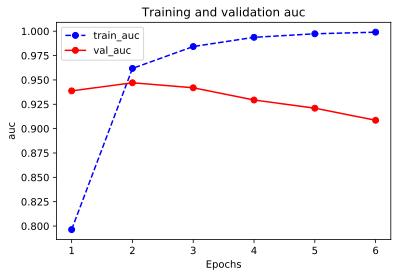

In [17]:
plot_metric(history,"auc")

In [18]:
history.history

{'loss': [0.523288369178772,
  0.25057774782180786,
  0.15925332903862,
  0.09660375863313675,
  0.05824233219027519,
  0.03395449370145798],
 'accuracy': [0.6962500214576721,
  0.8990499973297119,
  0.9401500225067139,
  0.9638500213623047,
  0.9796000123023987,
  0.9886500239372253],
 'auc': [0.7963460683822632,
  0.9617704749107361,
  0.9842618703842163,
  0.9937272071838379,
  0.9973549842834473,
  0.9990031719207764],
 'val_loss': [0.3423445522785187,
  0.3135015666484833,
  0.3665766716003418,
  0.4859156310558319,
  0.6167659759521484,
  0.851473331451416],
 'val_accuracy': [0.8460000157356262,
  0.8722000122070312,
  0.8664000034332275,
  0.8661999702453613,
  0.8632000088691711,
  0.8525999784469604],
 'val_auc': [0.9387553930282593,
  0.9470623731613159,
  0.9419249892234802,
  0.9293634295463562,
  0.920973002910614,
  0.908576488494873]}